# Student Exam Dataset - Regressão Logística Binária com PyTorch
## Objetivos
- Carregar e explorar o dataset **Student Exam**.
- Formular um problema de **classificação binária** (Pass/Fail).
- Implementar uma **Regressão Logística** usando PyTorch (`nn.Linear` + `BCEWithLogitsLoss`).
- Treinar o modelo com `torch.optim`.
- Avaliar desempenho (acurácia) e visualizar a fronteira de decisão em 2D.


## Importação das bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
torch.manual_seed(1234)


## Leitura e exploração do dataset Student Exam

In [2]:
# Lê o arquivo CSV do dataset Student Exam
# Lê o arquivo CSV do dataset Student Exam

import os
os.environ['KAGGLE_USERNAME'] = 'seu_usuario_kaggle'
os.environ['KAGGLE_KEY']      = 'sua_chave_kaggle'

# Download direto do arquivo CSV
!kaggle datasets download -d mrsimple07/student-exam-performance-prediction -f student_exam_data.csv -p ./data

# Ler o arquivo em Pandas
import pandas as pd
df = pd.read_csv('./data/student_exam_data.csv')

print('Formato do dataset:', df.shape)
print('\nColunas:', df.columns.tolist())
df.head()

print('Formato do dataset:', df.shape)
print('\nColunas:', df.columns.tolist())
df.head()

Dataset URL: https://www.kaggle.com/datasets/mrsimple07/student-exam-performance-prediction
License(s): apache-2.0

Formato do dataset: (500, 3)

Colunas: ['Study Hours', 'Previous Exam Score', 'Pass/Fail']
Formato do dataset: (500, 3)

Colunas: ['Study Hours', 'Previous Exam Score', 'Pass/Fail']



  0%|          | 0.00/18.7k [00:00<?, ?B/s]
100%|██████████| 18.7k/18.7k [00:00<00:00, 9.00MB/s]


,Study Hours,Previous Exam Score,Pass/Fail
0,4.370861,81.889703,0
1,9.556429,72.165782,1
2,7.587945,58.571657,0
3,6.387926,88.827701,1
4,2.404168,81.083870,0


In [3]:
# Estatísticas descritivas e balanceamento das classes
display(df.describe())
print('\nDistribuição da classe Pass/Fail:')
print(df['Pass/Fail'].value_counts(normalize=True))

,Study Hours,Previous Exam Score,Pass/Fail
count,500.000000,500.000000,500.000000
mean,5.487055,68.917084,0.368000
std,2.688196,17.129607,0.482744
min,1.045554,40.277921,0.000000
25%,3.171517,53.745955,0.000000
50%,5.618474,68.309294,0.000000
75%,7.805124,83.580209,1.000000
max,9.936683,99.983060,1.000000



Distribuição da classe Pass/Fail:
Pass/Fail
0    0.632
1    0.368
Name: proportion, dtype: float64


### Visualização inicial dos dados (Study Hours vs Previous Exam Score)

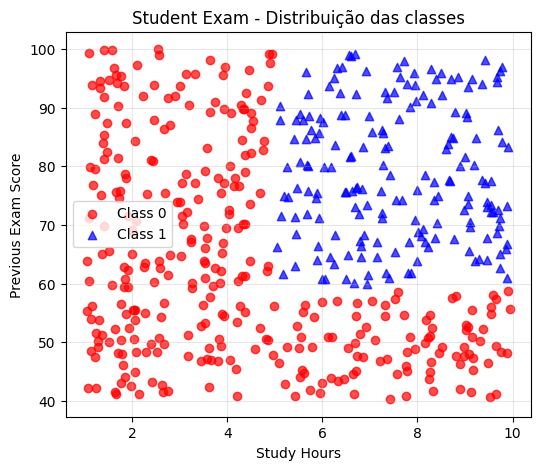

In [4]:
plt.figure(figsize=(6,5))
for label, marker, color in [(0, 'o', 'red'), (1, '^', 'blue')]:
    subset = df[df['Pass/Fail'] == label]
    plt.scatter(subset['Study Hours'], subset['Previous Exam Score'], 
                marker=marker, color=color, alpha=0.7, label=f'Class {label}')
plt.xlabel('Study Hours')
plt.ylabel('Previous Exam Score')
plt.legend()
plt.title('Student Exam - Distribuição das classes')
plt.grid(True, alpha=0.3)
plt.show()

## Preparação dos dados: seleção de features, normalização e divisão treino/teste

In [5]:
# Escolhemos as duas features numéricas como entrada e a coluna Pass/Fail como alvo binário
X = df[['Study Hours', 'Previous Exam Score']].values.astype(np.float32)
y = df['Pass/Fail'].values.astype(np.float32)

# Normalização Min-Max por feature (apenas em X)
X_min = X.min(axis=0, keepdims=True)
X_max = X.max(axis=0, keepdims=True)
X_norm = (X - X_min) / (X_max - X_min)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train mean (proporção de 1s):', y_train.mean())

X_train shape: (400, 2)
X_test shape: (100, 2)
y_train mean (proporção de 1s): 0.37


### Conversão para tensores do PyTorch

In [6]:
X_train_tensor = torch.from_numpy(X_train)
X_test_tensor  = torch.from_numpy(X_test)
y_train_tensor = torch.from_numpy(y_train).view(-1,1)  # shape (N,1)
y_test_tensor  = torch.from_numpy(y_test).view(-1,1)

print('X_train_tensor:', X_train_tensor.shape, X_train_tensor.dtype)
print('y_train_tensor:', y_train_tensor.shape, y_train_tensor.dtype)

X_train_tensor: torch.Size([400, 2]) torch.float32
y_train_tensor: torch.Size([400, 1]) torch.float32


## Construindo o modelo de Regressão Logística em PyTorch

In [7]:
# Modelo linear com 2 entradas e 1 saída (score logístico)
class LogisticRegressionNet(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.linear = nn.Linear(n_in, 1)  # saída escalar (logit)

    def forward(self, x):
        # Retorna o logit (sem sigmoid); a sigmoid será aplicada dentro da função de perda ou na inferência
        return self.linear(x)

model = LogisticRegressionNet(n_in=2)
print(model)

LogisticRegressionNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


### Testando o forward com algumas amostras

In [8]:
with torch.no_grad():
    logits_sample = model(X_train_tensor[:5])
    probs_sample = torch.sigmoid(logits_sample)
print('Logits (primeiras 5 amostras):\n', logits_sample)
print('\nProbabilidades (sigmoid):\n', probs_sample)

Logits (primeiras 5 amostras):
 tensor([[-0.9978],
        [-0.4771],
        [-0.5529],
        [-0.8272],
        [-0.3649]])

Probabilidades (sigmoid):
 tensor([[0.2694],
        [0.3829],
        [0.3652],
        [0.3042],
        [0.4098]])


## Definição da função de perda e otimizador

In [9]:
# Para classificação binária, usamos BCEWithLogitsLoss,
# que combina sigmoid + Binary Cross-Entropy de forma estável numericamente.
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


## Treinamento do modelo (Gradiente Descendente via optimizer do PyTorch)

In [10]:
num_epochs = 2000
loss_history = []
loss_history_test = []
acc_history = []
acc_history_test = []

for epoch in range(num_epochs):
    # Forward
    logits = model(X_train_tensor)
    logits_test = model(X_test_tensor)

    # Loss (treino e teste)
    loss = criterion(logits, y_train_tensor)
    loss_test = criterion(logits_test, y_test_tensor)

    # Backward + otimização
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Registro de métricas
    with torch.no_grad():
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        acc = (preds == y_train_tensor).float().mean()

        probs_test = torch.sigmoid(logits_test)
        preds_test = (probs_test >= 0.5).float()
        acc_test = (preds_test == y_test_tensor).float().mean()

    loss_history.append(loss.item())
    loss_history_test.append(loss_test.item())
    acc_history.append(acc.item())
    acc_history_test.append(acc_test.item())

    if (epoch+1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss train: {loss.item():.4f}, Loss test: {loss_test.item():.4f}, "
              f"Acc train: {acc.item():.4f}, Acc test: {acc_test.item():.4f}")

print('\nTreinamento concluído.')


Epoch [200/2000], Loss train: 0.5731, Loss test: 0.5774, Acc train: 0.7475, Acc test: 0.6900
Epoch [400/2000], Loss train: 0.4932, Loss test: 0.5028, Acc train: 0.8450, Acc test: 0.8300
Epoch [600/2000], Loss train: 0.4433, Loss test: 0.4572, Acc train: 0.8725, Acc test: 0.8400
Epoch [800/2000], Loss train: 0.4097, Loss test: 0.4270, Acc train: 0.8725, Acc test: 0.8500
Epoch [1000/2000], Loss train: 0.3855, Loss test: 0.4059, Acc train: 0.8775, Acc test: 0.8600
Epoch [1200/2000], Loss train: 0.3674, Loss test: 0.3904, Acc train: 0.8775, Acc test: 0.8600
Epoch [1400/2000], Loss train: 0.3533, Loss test: 0.3785, Acc train: 0.8750, Acc test: 0.8700
Epoch [1600/2000], Loss train: 0.3420, Loss test: 0.3692, Acc train: 0.8750, Acc test: 0.8800
Epoch [1800/2000], Loss train: 0.3328, Loss test: 0.3618, Acc train: 0.8725, Acc test: 0.8700
Epoch [2000/2000], Loss train: 0.3251, Loss test: 0.3557, Acc train: 0.8700, Acc test: 0.8700

Treinamento concluído.


### Curvas de perda e acurácia (treino x teste)

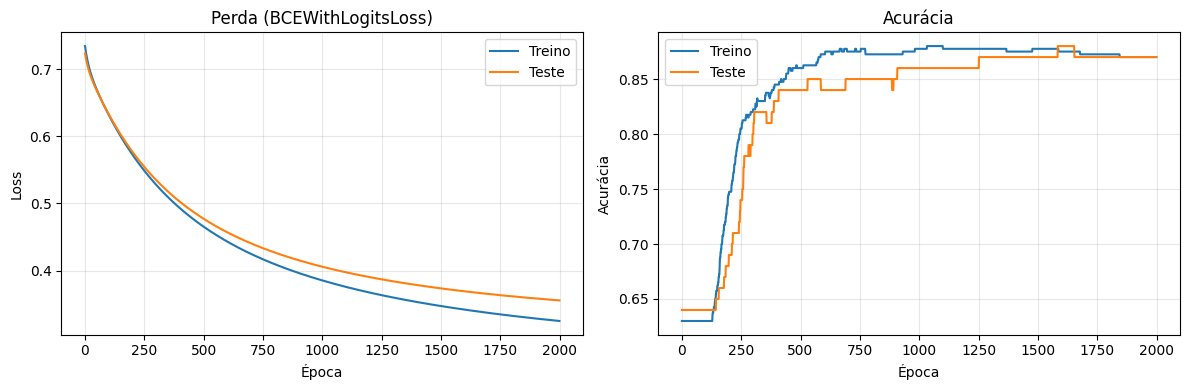

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(loss_history, label='Treino')
axs[0].plot(loss_history_test, label='Teste')
axs[0].set_title('Perda (BCEWithLogitsLoss)')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Loss')
axs[0].grid(True, alpha=0.3)
axs[0].legend()

axs[1].plot(acc_history, label='Treino')
axs[1].plot(acc_history_test, label='Teste')
axs[1].set_title('Acurácia')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('Acurácia')
axs[1].grid(True, alpha=0.3)
axs[1].legend()

plt.tight_layout()
plt.show()

## Avaliação final do modelo

In [12]:
with torch.no_grad():
    logits_train = model(X_train_tensor)
    probs_train = torch.sigmoid(logits_train)
    preds_train = (probs_train >= 0.5).float()
    acc_train = (preds_train == y_train_tensor).float().mean().item()

    logits_test = model(X_test_tensor)
    probs_test = torch.sigmoid(logits_test)
    preds_test = (probs_test >= 0.5).float()
    acc_test = (preds_test == y_test_tensor).float().mean().item()

print(f"Acurácia final (treino): {acc_train:.4f}")
print(f"Acurácia final (teste):  {acc_test:.4f}")

print('\nContagem de predições no conjunto de teste:')
print(pd.crosstab(y_test_tensor.view(-1).numpy(), preds_test.view(-1).numpy(),
                  rownames=['Real'], colnames=['Predito']))

Acurácia final (treino): 0.8700
Acurácia final (teste):  0.8700

Contagem de predições no conjunto de teste:
Predito  0.0  1.0
Real             
0.0       59    5
1.0        8   28


## Visualização da fronteira de decisão em 2D

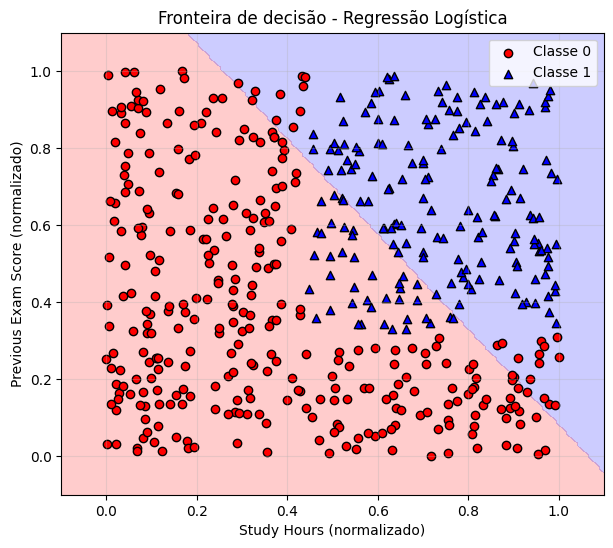

In [13]:
# Gera um grid no espaço das features normalizadas
x_min, x_max = X_norm[:,0].min()-0.1, X_norm[:,0].max()+0.1
y_min, y_max = X_norm[:,1].min()-0.1, X_norm[:,1].max()+0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
grid_tensor = torch.from_numpy(grid)

with torch.no_grad():
    logits_grid = model(grid_tensor)
    probs_grid = torch.sigmoid(logits_grid).view(-1).numpy()

Z = (probs_grid >= 0.5).astype(np.int32).reshape(xx.shape)

plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.2, levels=[-0.1,0.5,1.1], colors=['red','blue'])

for label, marker, color in [(0, 'o', 'red'), (1, '^', 'blue')]:
    subset = X_norm[y==label]
    plt.scatter(subset[:,0], subset[:,1], marker=marker, color=color, edgecolor='k', label=f'Classe {label}')

plt.xlabel('Study Hours (normalizado)')
plt.ylabel('Previous Exam Score (normalizado)')
plt.title('Fronteira de decisão - Regressão Logística')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🧠 Aprendizados Finais
- Como transformar o dataset **Student Exam** em um problema de **classificação binária (Pass/Fail)**.
- Como preparar os dados: seleção de features, normalização e divisão treino/teste.
- Construção de um modelo de **Regressão Logística com PyTorch** (`nn.Linear` + `BCEWithLogitsLoss`).
- Uso do **autograd** (`loss.backward()`) e do **optimizer** (`torch.optim.SGD`) para treinar o modelo.
- Cálculo e visualização de **curvas de perda e acurácia**.
- Visualização da **fronteira de decisão em 2D**, relacionando a teoria da regressão logística com a interpretação geométrica.
